# Cluster Drivers

Developed by Siobhan Powell, 2021.

## Precondition clustering on energy
To ensure the link between energy and driver cluster in the graphical model, we divide the drivers by their total energy use and cluster to identify behaviour groups within each energy bin. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture as GMM
import scipy.cluster.hierarchy as shc
import pickle

In [ ]:
s3_data_location = '' # fill in with own location

# Prepare data

In [3]:
driver_subset = pd.read_csv(s3_data_location+'sessions'+'2019'+'_driverdata_revised_pev_extra.csv', index_col=0)

### Clean

Remove drivers with little energy use in the data; assumes they are charging outside the data set in another network for most of their miles. 

In [4]:
print(len(driver_subset[driver_subset['Total Energy']<1000]) / len(driver_subset))
print(len(driver_subset[driver_subset['Total Energy']<250]) / len(driver_subset))
print(len(driver_subset[driver_subset['Num Sessions']!=(driver_subset['Num Workplace Sessions'] + driver_subset['Num Single Family Residential Sessions'] + driver_subset['Num MUD Sessions'] + driver_subset['Num Other Slow Sessions'] + driver_subset['Num Other Fast Sessions'])]) / len(driver_subset))

len1 = len(driver_subset)
print('Initial length: '+str(len(driver_subset)))
driver_subset = driver_subset.loc[(driver_subset['Total Energy']>=250)&(driver_subset['Num Sessions']==(driver_subset['Num Workplace Sessions'] + driver_subset['Num Single Family Residential Sessions'] + driver_subset['Num MUD Sessions'] + driver_subset['Num Other Slow Sessions'] + driver_subset['Num Other Fast Sessions']))].reset_index(drop=True).copy(deep=True)
print(len(driver_subset)/len1)

0.39366411205074
0.04208509513742072
0.015228594080338267
Initial length: 30272
0.9436773255813954


In [5]:
print(len(driver_subset))

28567


In [9]:
main_cols = np.array(['Battery Capacity',
       'Num Workplace Sessions', 'Num Single Family Residential Sessions',
       'Num MUD Sessions', 'Num Other Slow Sessions',
       'Num Other Fast Sessions', 'Work - Session energy - mean',
       'Work - Session time - mean', 'Work - Start hour - mean',
       'Work - Weekend fraction', 'Other Fast - Session energy - mean',
       'Other Fast - Session time - mean',
       'Other Fast - Start hour - mean', 'Other Fast - Weekend fraction',
       'Other Slow - Session energy - mean',
       'Other Slow - Session time - mean',
       'Other Slow - Start hour - mean', 'Other Slow - Weekend fraction',
       'MUD - Session energy - mean', 'MUD - Session time - mean',
       'MUD - Start hour - mean', 'MUD - Weekend fraction',
       'Home - Session energy - mean', 'Home - Session time - mean',
       'Home - Start hour - mean', 'Home - Weekend fraction'])

In [13]:
# Fill any missing data
for key in driver_subset.isna().sum()[driver_subset.isna().sum() > 0].keys()[1:]:
    driver_subset[key] = driver_subset[key].fillna(0)

In [14]:
driver_subset.isna().sum()[driver_subset.isna().sum() > 0]

Battery Capacity    132
dtype: int64

In [15]:
# Drop drivers with missing battery capacity data
print('Num before: ',driver_subset.shape[0])
driver_subset = driver_subset.dropna(axis=0, subset=main_cols)
print('Num after: ',driver_subset.shape[0])

Num before:  28567
Num after:  28435


In [16]:
old_driver_subset = driver_subset.copy(deep=True)

In [17]:
oldlen = len(old_driver_subset)
for col in main_cols:
    driver_subset = driver_subset[driver_subset[col] < np.percentile(driver_subset[col], 99.99)]
print(len(driver_subset) / oldlen)

0.9752066115702479


In [18]:
len(driver_subset)

27730

## Preprocess data fro clustering

In [20]:
def normalize_df(df, cols_keep):
    
    scaling_df = {'Col':[], 'Shift':[], 'Denom':[]}
    df_here = df.loc[:, cols_keep]
    for col in cols_keep:
        scaling_df['Col'].append(col)
        scaling_df['Shift'].append(df_here[col].min())
        scaling_df['Denom'].append(df_here[col].max()-df_here[col].min())
        df_here[col] = (df_here[col]-df_here[col].min())/(df_here[col].max()-df_here[col].min())
    scaling_df = pd.DataFrame(scaling_df)

    return df_here, scaling_df

def rescale(df, scaling_df, cols):
    
    rescaled_df = df.loc[:, cols].copy(deep=True)
    for col in cols:
        rescaled_df = clip_top_p(rescaled_df, col)
        idx = scaling_df.loc[scaling_df['Col']==col].index[0]
        rescaled_df[col] =  (df[col] - scaling_df.loc[idx, 'Shift']) / scaling_df.loc[idx, 'Denom']
    
    return rescaled_df

In [91]:
X_df, scaling_df = normalize_df(driver_subset, main_cols)

# Clustering

In [92]:
n = 0
epairs = [(0., 600.), (600.,1000.), (1000., 1600.), (1600., 2000.), (2000., 3000.), (3000., 4000.), (4000., 6000.)]

## Energy bin 1

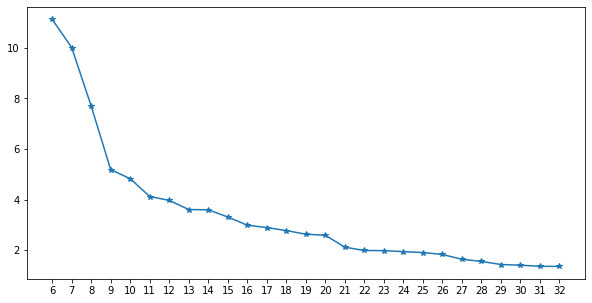

In [93]:
j = 0
epair = epairs[j]

inds = driver_subset.loc[(driver_subset['Total Energy']>epair[0])&(driver_subset['Total Energy']<=epair[1])].index
linkage = shc.linkage(X_df.loc[inds, :], method='ward')
heights1 = []
heights2 = []
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(2), no_plot=True)
oldmin = np.max(np.max(dend['dcoord'], axis=1))
nks = np.arange(3, 100)

for nk in nks:
    dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(nk), no_plot=True)
    heights1.append(oldmin - np.min(np.max(dend['dcoord'], axis=1)))
    heights2.append(np.max(np.max(dend['dcoord'], axis=1)) - np.min(np.max(dend['dcoord'], axis=1)))
    oldmin = np.min(np.max(dend['dcoord'], axis=1))
    
plt.figure(figsize=(10,5))
plt.plot(nks[np.arange(3, 30)], (np.max(heights2)-heights2)[np.arange(3, 30)], '*-')
plt.xticks(nks[np.arange(3, 30)])
plt.show()

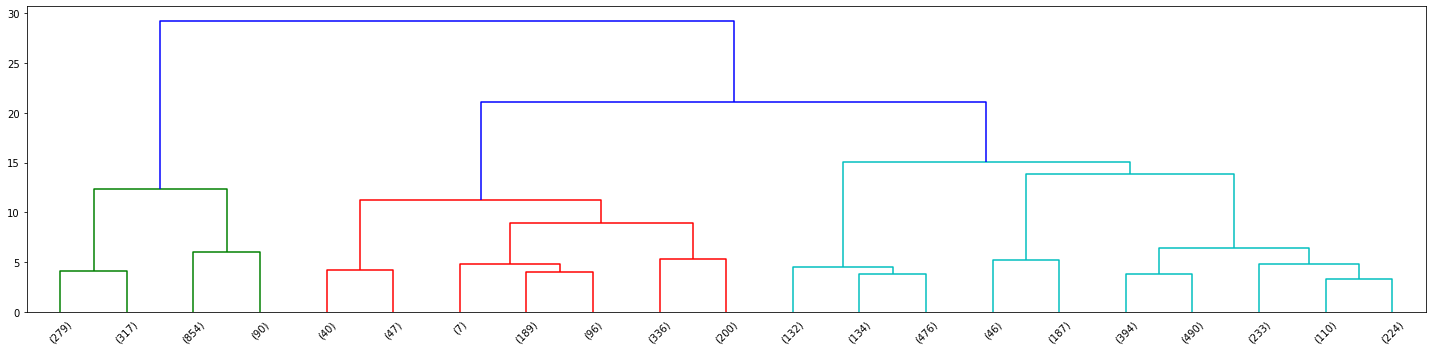

In [94]:
n_j = 21
ac = AgglomerativeClustering(n_clusters=n_j, affinity='euclidean', linkage='ward').fit_predict(X_df.loc[inds, :].values)
driver_subset.loc[inds, 'Agglom Cluster Number'] = ac

fig, axes = plt.subplots(1, 1, figsize=(20,5))
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=n_j, show_leaf_counts=True, ax=axes)
plt.tight_layout()
plt.savefig('dend_precondition_on_energy_set'+str(j)+'_clustnum'+str(n_j)+'.pdf', bbox_inches='tight')
plt.show()
# X_df.loc[inds, 'Agglom Cluster Number'] = ac

In [95]:
n = n + n_j

## Energy bin 2

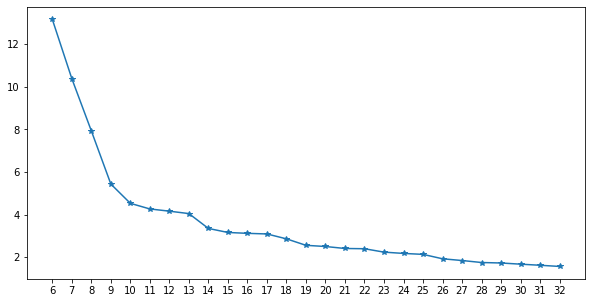

In [96]:
j = 1
epair = epairs[j]

inds = driver_subset.loc[(driver_subset['Total Energy']>epair[0])&(driver_subset['Total Energy']<=epair[1])].index
linkage = shc.linkage(X_df.loc[inds, :], method='ward')
heights1 = []
heights2 = []
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(2), no_plot=True)
oldmin = np.max(np.max(dend['dcoord'], axis=1))
nks = np.arange(3, 100)

for nk in nks:
    dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(nk), no_plot=True)
    heights1.append(oldmin - np.min(np.max(dend['dcoord'], axis=1)))
    heights2.append(np.max(np.max(dend['dcoord'], axis=1)) - np.min(np.max(dend['dcoord'], axis=1)))
    oldmin = np.min(np.max(dend['dcoord'], axis=1))
    
plt.figure(figsize=(10,5))
plt.plot(nks[np.arange(3, 30)], (np.max(heights2)-heights2)[np.arange(3, 30)], '*-')
plt.xticks(nks[np.arange(3, 30)])
plt.show()

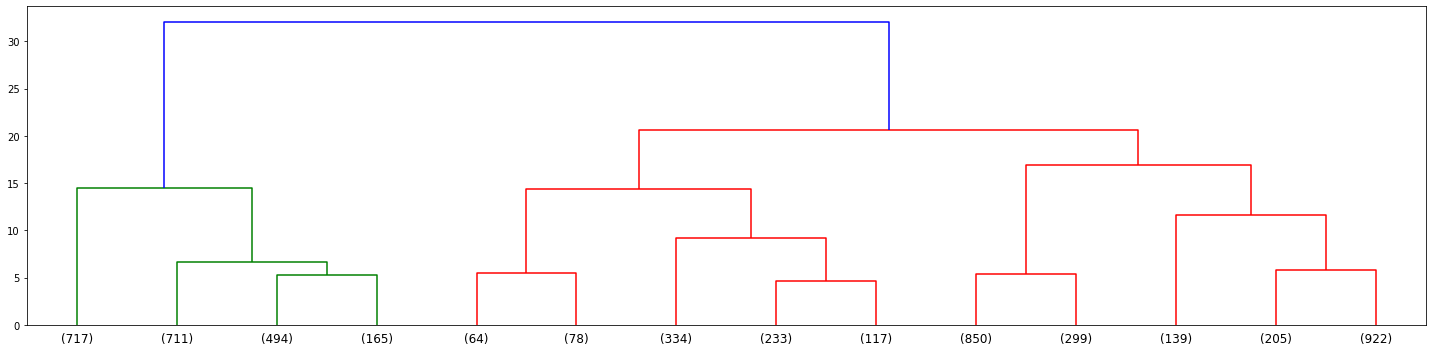

In [97]:
n_j = 14
ac = AgglomerativeClustering(n_clusters=n_j, affinity='euclidean', linkage='ward').fit_predict(X_df.loc[inds, :].values)
driver_subset.loc[inds, 'Agglom Cluster Number'] = ac+n
# X_df.loc[inds, 'Agglom Cluster Number'] = ac
fig, axes = plt.subplots(1, 1, figsize=(20,5))
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=n_j, show_leaf_counts=True, ax=axes)
plt.tight_layout()
plt.savefig('dend_precondition_on_energy_set'+str(j)+'_clustnum'+str(n_j)+'.pdf', bbox_inches='tight')
plt.show()


In [98]:
n = n + n_j

## Energy bin 3

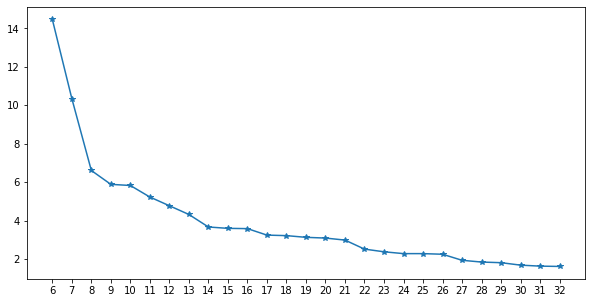

In [99]:
j = 2
epair = epairs[j]

inds = driver_subset.loc[(driver_subset['Total Energy']>epair[0])&(driver_subset['Total Energy']<=epair[1])].index
linkage = shc.linkage(X_df.loc[inds, :], method='ward')
heights1 = []
heights2 = []
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(2), no_plot=True)
oldmin = np.max(np.max(dend['dcoord'], axis=1))
nks = np.arange(3, 100)

for nk in nks:
    dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(nk), no_plot=True)
    heights1.append(oldmin - np.min(np.max(dend['dcoord'], axis=1)))
    heights2.append(np.max(np.max(dend['dcoord'], axis=1)) - np.min(np.max(dend['dcoord'], axis=1)))
    oldmin = np.min(np.max(dend['dcoord'], axis=1))
    
plt.figure(figsize=(10,5))
plt.plot(nks[np.arange(3, 30)], (np.max(heights2)-heights2)[np.arange(3, 30)], '*-')
plt.xticks(nks[np.arange(3, 30)])
plt.show()

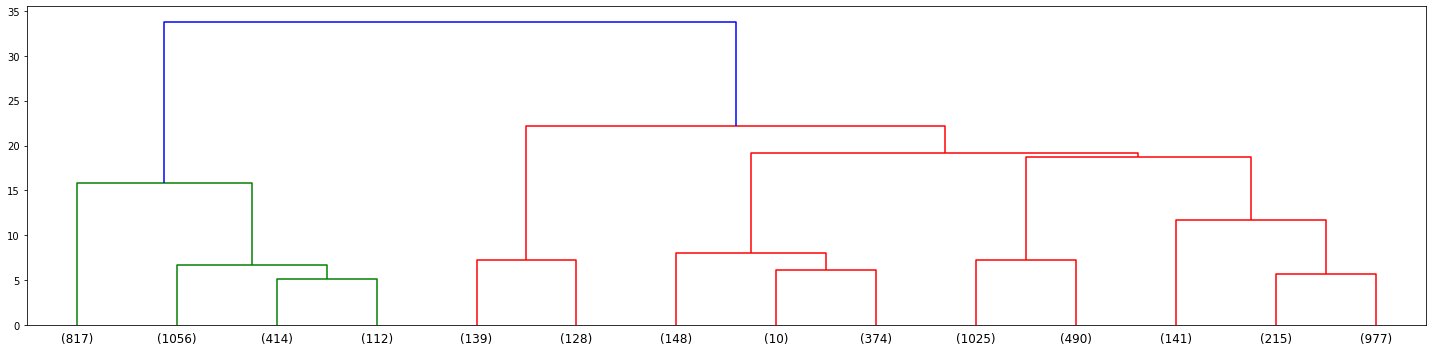

In [100]:
n_j = 14
ac = AgglomerativeClustering(n_clusters=n_j, affinity='euclidean', linkage='ward').fit_predict(X_df.loc[inds, :].values)
driver_subset.loc[inds, 'Agglom Cluster Number'] = ac+n
# X_df.loc[inds, 'Agglom Cluster Number'] = ac
fig, axes = plt.subplots(1, 1, figsize=(20,5))
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=n_j, show_leaf_counts=True, ax=axes)
plt.tight_layout()
plt.savefig('dend_precondition_on_energy_set'+str(j)+'_clustnum'+str(n_j)+'.pdf', bbox_inches='tight')
plt.show()


In [101]:
n = n + n_j

## Energy bin 4

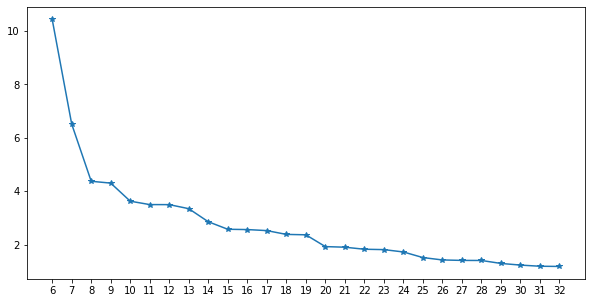

In [102]:
j = 3
epair = epairs[j]

inds = driver_subset.loc[(driver_subset['Total Energy']>epair[0])&(driver_subset['Total Energy']<=epair[1])].index
linkage = shc.linkage(X_df.loc[inds, :], method='ward')
heights1 = []
heights2 = []
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(2), no_plot=True)
oldmin = np.max(np.max(dend['dcoord'], axis=1))
nks = np.arange(3, 100)

for nk in nks:
    dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(nk), no_plot=True)
    heights1.append(oldmin - np.min(np.max(dend['dcoord'], axis=1)))
    heights2.append(np.max(np.max(dend['dcoord'], axis=1)) - np.min(np.max(dend['dcoord'], axis=1)))
    oldmin = np.min(np.max(dend['dcoord'], axis=1))
    
plt.figure(figsize=(10,5))
plt.plot(nks[np.arange(3, 30)], (np.max(heights2)-heights2)[np.arange(3, 30)], '*-')
plt.xticks(nks[np.arange(3, 30)])
plt.show()

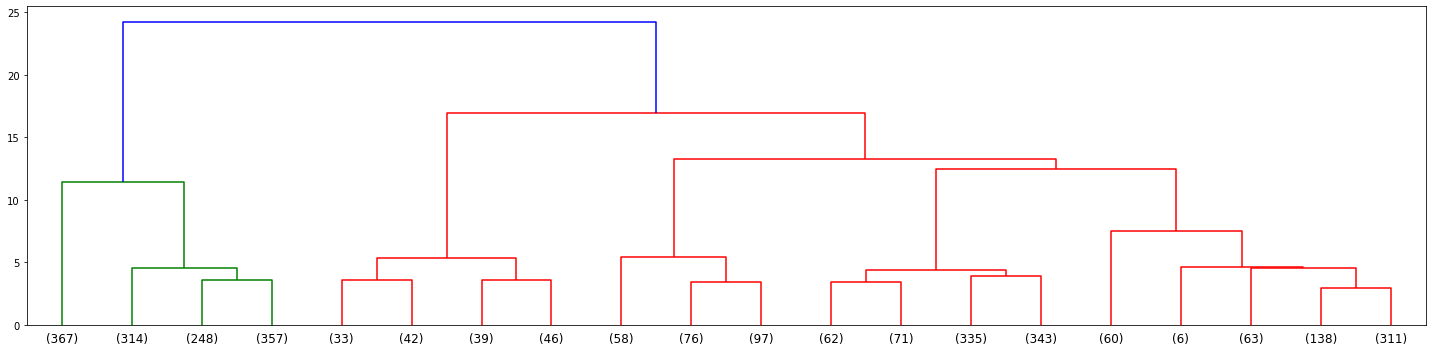

In [103]:
n_j = 20
ac = AgglomerativeClustering(n_clusters=n_j, affinity='euclidean', linkage='ward').fit_predict(X_df.loc[inds, :].values)
driver_subset.loc[inds, 'Agglom Cluster Number'] = ac+n
# X_df.loc[inds, 'Agglom Cluster Number'] = ac
fig, axes = plt.subplots(1, 1, figsize=(20,5))
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=n_j, show_leaf_counts=True, ax=axes)
plt.tight_layout()
plt.savefig('dend_precondition_on_energy_set'+str(j)+'_clustnum'+str(n_j)+'.pdf', bbox_inches='tight')
plt.show()


In [104]:
n = n + n_j

## Energy bin 5

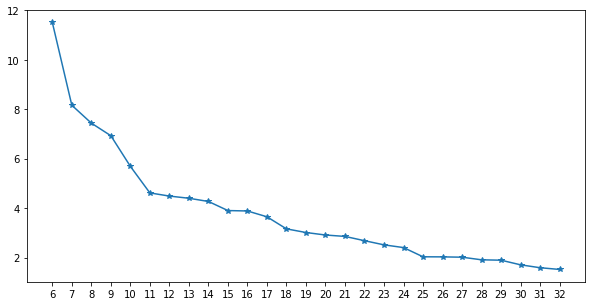

In [105]:
j = 4
epair = epairs[j]

inds = driver_subset.loc[(driver_subset['Total Energy']>epair[0])&(driver_subset['Total Energy']<=epair[1])].index
linkage = shc.linkage(X_df.loc[inds, :], method='ward')
heights1 = []
heights2 = []
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(2), no_plot=True)
oldmin = np.max(np.max(dend['dcoord'], axis=1))
nks = np.arange(3, 100)

for nk in nks:
    dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(nk), no_plot=True)
    heights1.append(oldmin - np.min(np.max(dend['dcoord'], axis=1)))
    heights2.append(np.max(np.max(dend['dcoord'], axis=1)) - np.min(np.max(dend['dcoord'], axis=1)))
    oldmin = np.min(np.max(dend['dcoord'], axis=1))
    
plt.figure(figsize=(10,5))
plt.plot(nks[np.arange(3, 30)], (np.max(heights2)-heights2)[np.arange(3, 30)], '*-')
plt.xticks(nks[np.arange(3, 30)])
plt.show()

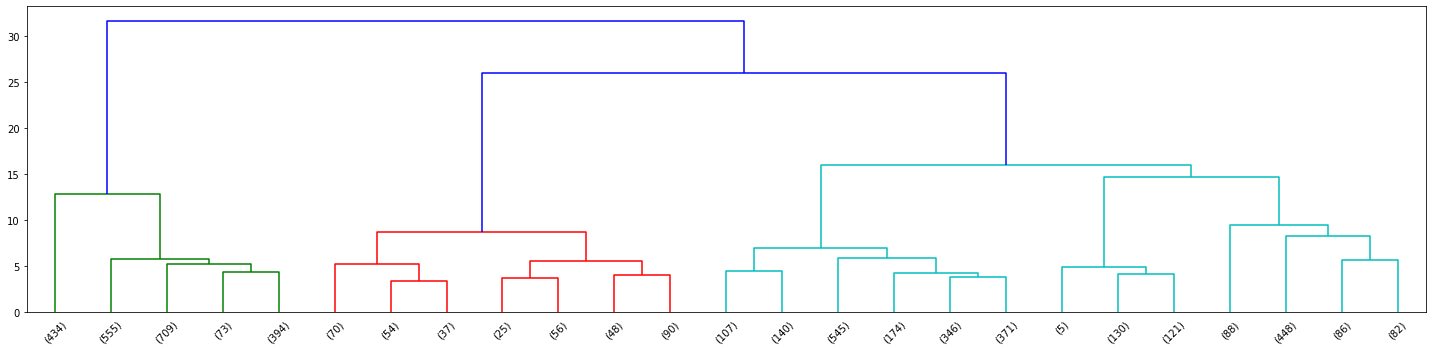

In [106]:
n_j = 25
ac = AgglomerativeClustering(n_clusters=n_j, affinity='euclidean', linkage='ward').fit_predict(X_df.loc[inds, :].values)
driver_subset.loc[inds, 'Agglom Cluster Number'] = ac+n
# X_df.loc[inds, 'Agglom Cluster Number'] = ac
fig, axes = plt.subplots(1, 1, figsize=(20,5))
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=n_j, show_leaf_counts=True, ax=axes)
plt.tight_layout()
plt.savefig('dend_precondition_on_energy_set'+str(j)+'_clustnum'+str(n_j)+'.pdf', bbox_inches='tight')
plt.show()


In [107]:
n = n + n_j

## Energy bin 6

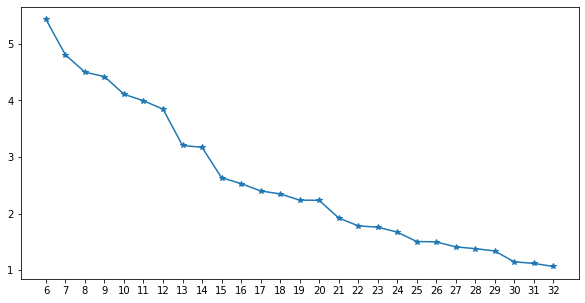

In [108]:
j = 5
epair = epairs[j]

inds = driver_subset.loc[(driver_subset['Total Energy']>epair[0])&(driver_subset['Total Energy']<=epair[1])].index
linkage = shc.linkage(X_df.loc[inds, :], method='ward')
heights1 = []
heights2 = []
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(2), no_plot=True)
oldmin = np.max(np.max(dend['dcoord'], axis=1))
nks = np.arange(3, 100)

for nk in nks:
    dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(nk), no_plot=True)
    heights1.append(oldmin - np.min(np.max(dend['dcoord'], axis=1)))
    heights2.append(np.max(np.max(dend['dcoord'], axis=1)) - np.min(np.max(dend['dcoord'], axis=1)))
    oldmin = np.min(np.max(dend['dcoord'], axis=1))
    
plt.figure(figsize=(10,5))
plt.plot(nks[np.arange(3, 30)], (np.max(heights2)-heights2)[np.arange(3, 30)], '*-')
plt.xticks(nks[np.arange(3, 30)])
plt.show()

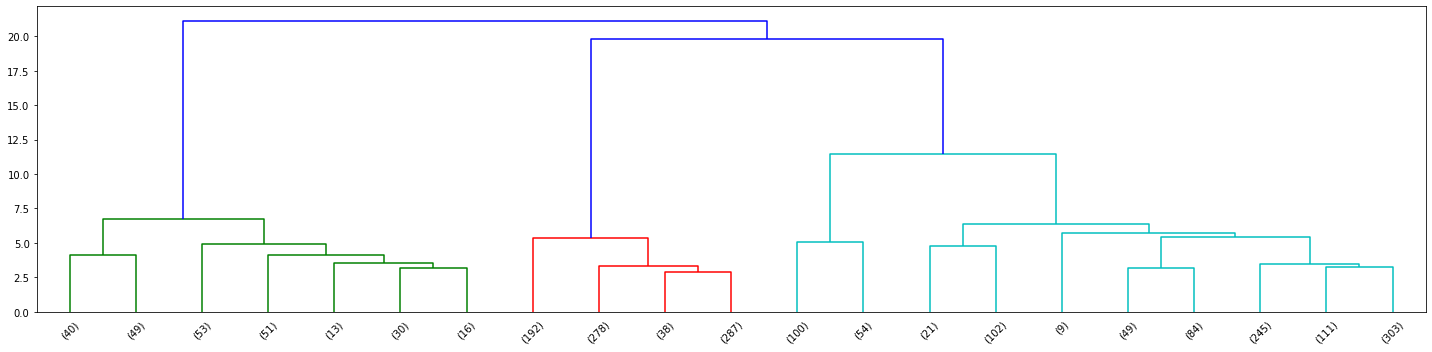

In [109]:
n_j = 21
ac = AgglomerativeClustering(n_clusters=n_j, affinity='euclidean', linkage='ward').fit_predict(X_df.loc[inds, :].values)
driver_subset.loc[inds, 'Agglom Cluster Number'] = ac+n
# X_df.loc[inds, 'Agglom Cluster Number'] = ac
fig, axes = plt.subplots(1, 1, figsize=(20,5))
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=n_j, show_leaf_counts=True, ax=axes)
plt.tight_layout()
plt.savefig('dend_precondition_on_energy_set'+str(j)+'_clustnum'+str(n_j)+'.pdf', bbox_inches='tight')
plt.show()


In [110]:
n = n + n_j

## Energy bin 7

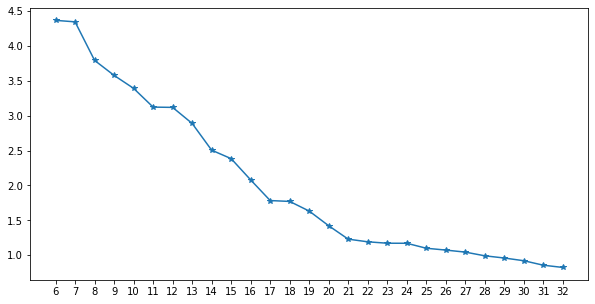

In [111]:
j = 6
epair = epairs[j]

inds = driver_subset.loc[(driver_subset['Total Energy']>epair[0])].index#&(driver_subset['Total Energy']<=epair[1])].index
linkage = shc.linkage(X_df.loc[inds, :], method='ward')
heights1 = []
heights2 = []
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(2), no_plot=True)
oldmin = np.max(np.max(dend['dcoord'], axis=1))
nks = np.arange(3, 100)

for nk in nks:
    dend = shc.dendrogram(linkage, truncate_mode='lastp', p=int(nk), no_plot=True)
    heights1.append(oldmin - np.min(np.max(dend['dcoord'], axis=1)))
    heights2.append(np.max(np.max(dend['dcoord'], axis=1)) - np.min(np.max(dend['dcoord'], axis=1)))
    oldmin = np.min(np.max(dend['dcoord'], axis=1))
    
plt.figure(figsize=(10,5))
plt.plot(nks[np.arange(3, 30)], (np.max(heights2)-heights2)[np.arange(3, 30)], '*-')
plt.xticks(nks[np.arange(3, 30)])
plt.show()

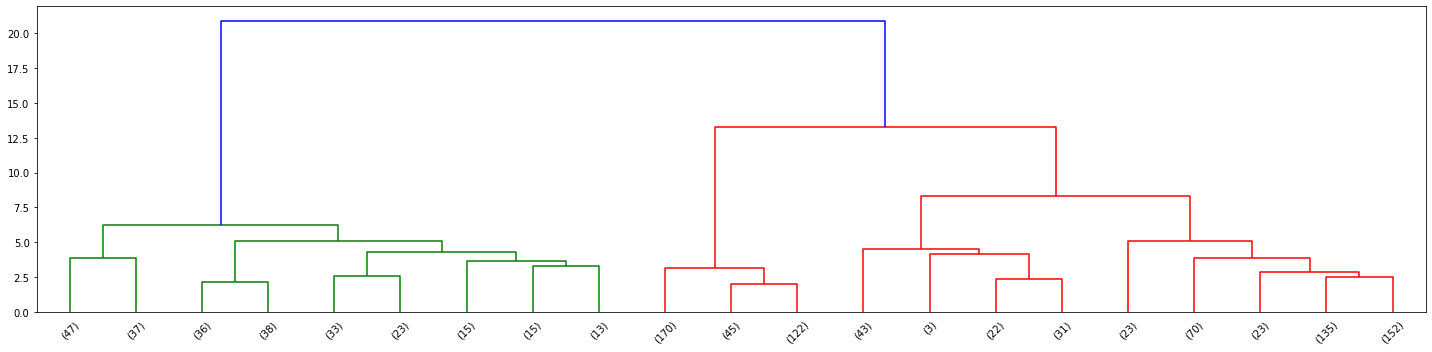

In [112]:
n_j = 21
ac = AgglomerativeClustering(n_clusters=n_j, affinity='euclidean', linkage='ward').fit_predict(X_df.loc[inds, :].values)
driver_subset.loc[inds, 'Agglom Cluster Number'] = ac+n
# X_df.loc[inds, 'Agglom Cluster Number'] = ac
fig, axes = plt.subplots(1, 1, figsize=(20,5))
dend = shc.dendrogram(linkage, truncate_mode='lastp', p=n_j, show_leaf_counts=True, ax=axes)
plt.tight_layout()
plt.savefig('dend_precondition_on_energy_set'+str(j)+'_clustnum'+str(n_j)+'.pdf', bbox_inches='tight')
plt.show()


In [113]:
n = n + n_j

In [114]:
driver_subset['Agglom Cluster Number'].isna().sum()

0

In [115]:
X_df['Agglom Cluster Number'] = driver_subset['Agglom Cluster Number'].values

In [116]:
n # total number of clusters

136

In [117]:
X_df['Agglom Cluster Number'].max()

135.0

# Save Model Features

Calculate the other model data for these 136 clusters.

In [118]:
import os
if not os.path.isdir('../Data/CP'+str(n)):
    os.mkdir('../Data/CP'+str(n))
if not os.path.isdir('../Data/CP'+str(n)+'/GMMs'):
    os.mkdir('../Data/CP'+str(n)+'/GMMs')

### P(G)

In [119]:
pg = pd.DataFrame(dict(driver_subset['Agglom Cluster Number'].value_counts(normalize=True)), index=['pg']).T.sort_index()
pg

,pg
0.0,0.017166
1.0,0.006744
2.0,0.001695
3.0,0.007212
4.0,0.003246
...,...
131.0,0.001190
132.0,0.004868
133.0,0.000793
134.0,0.000108


In [120]:
pg.to_csv('../Data/CP'+str(n)+'/pg.csv', index=None)

### P(z|G)

In [121]:
relabel = {'Home':'home_l2', 'Work':'work_l2', 'MUD':'mud_l2', 'Other Slow':'public_l2', 'Other Fast':'public_l3'}
col_mapping = {}
for key, val in relabel.items():
    for w in ['weekdays', 'weekenddays']:
        col_mapping[key+' - Fraction of '+w+' with session'] = val+' - Fraction of '+w+' with session'
for i in range(n):
    inds = driver_subset[driver_subset['Agglom Cluster Number']==i].index
    pz_subset = driver_subset.loc[inds, col_mapping.keys()].reset_index(drop=True)
    pz_subset = pz_subset.rename(columns=col_mapping)
    pz_subset['home_l1 - Fraction of weekdays with session'] = 0; pz_subset['home_l1 - Fraction of weekenddays with session'] = 0
    pz_subset.to_csv('../Data/CP'+str(n)+'/pz_weekday_g_'+str(i)+'.csv')
    pz_subset.to_csv('../Data/CP'+str(n)+'/pz_weekend_g_'+str(i)+'.csv')    


### P(s|z, G)

In [122]:
def process_df(df2):

    df2['start'] = np.clip(df2['start_seconds'], 0, 24*60*60)
    df2['energy'] = np.clip(df2['Energy (kWh)'], 0, 100)
    df2['duration'] = np.clip(df2['Session Time (secs)'], 0, 48*60*60)

    df2['location'] = 'other'
    df2.loc[df2[df2['POI Category']=='Single family residential'].index, 'location'] = 'home'
    df2.loc[df2[df2['POI Category']=='Workplace'].index, 'location'] = 'work'
    df2.loc[df2[df2['POI Category'].isin(['Multifamily Commercial', 'Multifamily Home Service'])].index, 'location'] = 'mud'
    df2['weekend'] = 'weekday'
    df2.loc[df2[df2['start_weekday'].isin([5, 6])].index, 'weekend'] = 'weekend'
    df2['bigbattery'] = 'smallbatt'
    df2.loc[df2[df2['Battery Capacity']>=50].index, 'bigbattery'] = 'bigbatt'
    df2['fast'] = 'slow'
    df2.loc[df2[df2['Max Power']>20].index, 'fast'] = 'fast'
    
    return df2

def create_gmms(df2, group_number, n):
    
    print(group_number)
    
    loc_cat_mapping1 = {'home':'home_l2', 'work':'work_l2', 'mud':'mud_l2'}
    loc_cat_mapping2 = {'slow':'public_l2', 'fast':'public_l3'}
    
    for loc in ['home', 'other', 'work', 'mud']:
        subset = df2[df2['location']==loc]
        if len(subset) > 0:
            if loc=='other':
                speed_set = ['fast', 'slow']
            else:
                speed_set = ['slow']
            for speed in speed_set:
                subset1 = subset[subset['fast']==speed]
                if len(subset1) > 0:
                    for weekend in ['weekday','weekend']:
                        subset2 = subset1[subset1['weekend']==weekend]
                        if len(subset2) > 0:
                            if loc in loc_cat_mapping1.keys():
                                cat = loc_cat_mapping1[loc]
                            else:
                                cat = loc_cat_mapping2[speed]
                            name_str = '../Data/CP'+str(n)+'/GMMs/'+weekend+'_'+cat+'_'+str(group_number)+'.p'
                            fit_gmm(subset2, name_str)

    return

def fit_gmm(subset, name_str):
    
    mat = subset[['start','energy','duration']].values
    minshape = np.shape(mat)[0]
    if minshape > 10:
        if minshape > 50:
            num_components = 10
        else:
            num_components = 1
        gm = GMM(n_components=num_components).fit(mat)
        pickle.dump(gm, open(name_str, "wb"))
        
    return

In [5]:
year = 2019
filename_end = 'sessions'+str(int(year))
df = pd.read_csv(s3_data_location+filename_end+'.csv', index_col=0)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [174]:
df = process_df(df)

In [125]:
for i in range(n):
    drivers = driver_subset[driver_subset['Agglom Cluster Number']==i]['Unique Driver ID'].values
    df2 = df[df['Driver ID'].isin(drivers)]
    create_gmms(df2, i, n)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135


### P(G | A, B, E), P(A), P(B), P(E)

In [127]:
driver_subset_data = driver_subset.loc[:, ['Unique Driver ID', 'Total Energy', 'B_flag_large', 'A_flag_home', 'A_flag_work_price']].copy(deep=True)
driver_subset_data = driver_subset_data[driver_subset_data['Unique Driver ID'].isin(driver_subset['Unique Driver ID'].values)].copy(deep=True).reset_index(drop=True)
for i in range(n):
    idx1 = driver_subset[driver_subset['Agglom Cluster Number']==i].index
    idx2 = driver_subset_data[driver_subset_data['Unique Driver ID'].isin(driver_subset.loc[idx1, 'Unique Driver ID'].values)].index
    driver_subset_data.loc[idx2, 'Agglom Cluster Number'] = i
driver_subset_data['Agglom Cluster Number'] = driver_subset_data['Agglom Cluster Number'].astype(int)


In [128]:
driver_subset_data.to_csv('driver_data_save_n'+str(n)+'_20211119.csv')

In [129]:
driver_subset_data

,Unique Driver ID,Total Energy,B_flag_large,A_flag_home,A_flag_work_price,Agglom Cluster Number
0,4456451.0,923.419581,1,0,free,29
1,1048591.0,2184.699083,0,0,free,80
2,2883621.0,3376.675261,1,0,0,95
3,3407911.0,3084.040603,1,0,free,112
4,524337.0,1098.721322,0,0,0,42
...,...,...,...,...,...,...
27722,786379.0,538.372363,0,0,free,9
27723,19922901.0,975.438785,1,0,free,33
27724,262103.0,1250.320371,0,0,paid,40
27725,524259.0,834.361576,0,0,0,24


In [132]:
def plot_dist(inds, n, plot=True, clust='Agglom Cluster Number'):
    
    cts = driver_subset_data.loc[inds, clust].value_counts()
    vals = np.zeros((n, ))
    for key, val in cts.items():
        vals[key] = val

    vals = vals / np.sum(vals)
    if plot:
        plt.figure()
        plt.bar(np.arange(1, n+1), vals)
        plt.ylim([0, 1]); plt.xticks(np.arange(1, n+1)); plt.ylabel('P(G)'); plt.xlabel('G')
        plt.show()
    
    return vals

In [3]:
import pandas as pd
import numpy as np
n = 136
driver_subset_test = pd.read_csv('driver_data_save_n136_20211119.csv', index_col=0)

In [11]:
epairs = [(0., 600.), (600.,1000.), (1000., 1600.), (1600., 2000.), (2000., 3000.), (3000., 4000.), (4000., 6000.)]
# pg_abe2 = {}
home_labels = {'0':'0', 'l2':'l2', 'mud':'mud'}
work_labels = {'0':'0', 'free':'free', 'paid':'paid'}
for bflag in [0, 1]:
    print('Battery: ', bflag)
    for aflag_home in ['mud']:# ['0', 'l2', 'mud']:
        for aflag_work in ['0', 'paid', 'free']:
            print('Awork: ', aflag_work)
            test2 = pd.DataFrame(np.zeros((len(epairs),2)), columns=['Epair', 'NumDrivers'])
            for j, epair in enumerate(epairs):
                test2.loc[j, 'Epair'] = epair[0]
                inds = driver_subset_test.loc[(driver_subset_test['Total Energy']>epair[0])&(driver_subset_test['Total Energy']<=epair[1])&(driver_subset_test['B_flag_large']==bflag)&(driver_subset_test['A_flag_home']==aflag_home)&(driver_subset_test['A_flag_work_price']==aflag_work)].index
                test2.loc[j, 'NumDrivers'] = len(inds)
            print(test2)


Battery:  0
Awork:  0
    Epair  NumDrivers
0     0.0         1.0
1   600.0         1.0
2  1000.0         2.0
3  1600.0         1.0
4  2000.0         0.0
5  3000.0         0.0
6  4000.0         0.0
Awork:  paid
    Epair  NumDrivers
0     0.0         0.0
1   600.0         1.0
2  1000.0         0.0
3  1600.0         2.0
4  2000.0         0.0
5  3000.0         0.0
6  4000.0         0.0
Awork:  free
    Epair  NumDrivers
0     0.0         0.0
1   600.0         1.0
2  1000.0         1.0
3  1600.0         0.0
4  2000.0         0.0
5  3000.0         0.0
6  4000.0         0.0
Battery:  1
Awork:  0
    Epair  NumDrivers
0     0.0         4.0
1   600.0         1.0
2  1000.0         7.0
3  1600.0         0.0
4  2000.0         5.0
5  3000.0         4.0
6  4000.0         3.0
Awork:  paid
    Epair  NumDrivers
0     0.0         1.0
1   600.0         0.0
2  1000.0         0.0
3  1600.0         2.0
4  2000.0         0.0
5  3000.0         1.0
6  4000.0         0.0
Awork:  free
    Epair  NumDrivers
0 

In [134]:
epairs = [(0., 600.), (600.,1000.), (1000., 1600.), (1600., 2000.), (2000., 3000.), (3000., 4000.), (4000., 6000.)]
pg_abe2 = {}
home_labels = {'0':'0', 'l2':'l2', 'mud':'mud'}
work_labels = {'0':'0', 'free':'free', 'paid':'paid'}
for bflag in [0, 1]:
    for aflag_home in ['0', 'l2', 'mud']:
        for aflag_work in ['0', 'paid', 'free']:
            for j, epair in enumerate(epairs):
                inds = driver_subset_data.loc[(driver_subset_data['Total Energy']>epair[0])&(driver_subset_data['Total Energy']<=epair[1])&(driver_subset_data['B_flag_large']==bflag)&(driver_subset_data['A_flag_home']==aflag_home)&(driver_subset_data['A_flag_work_price']==aflag_work)].index
                vals = plot_dist(inds, n, clust='Agglom Cluster Number', plot=False)
                pg_abe2['work_'+work_labels[aflag_work]+'_home_'+home_labels[aflag_home]+'_largebattery_'+str(bflag)+'_energy_'+str(int(epairs[j][0]))+'_'+str(int(epairs[j][1]))] = vals
                if aflag_home == '0':
                    pg_abe2['work_'+str(aflag_work)+'_home_'+'l1'+'_largebattery_'+str(bflag)+'_energy_'+str(int(epairs[j][0]))+'_'+str(int(epairs[j][1]))] = vals
                    
                
pg_abe2 = pd.DataFrame(pg_abe2)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


#### Some groups have no mud drivers in them: we fill those in by taking the P(G|A,B,E) for the nearest groups that do. 

In [141]:
pg_abe2.sum()[pg_abe2.sum() == 0]

work_0_home_mud_largebattery_0_energy_2000_3000       0.0
work_0_home_mud_largebattery_0_energy_3000_4000       0.0
work_0_home_mud_largebattery_0_energy_4000_6000       0.0
work_paid_home_mud_largebattery_0_energy_0_600        0.0
work_paid_home_mud_largebattery_0_energy_1000_1600    0.0
work_paid_home_mud_largebattery_0_energy_2000_3000    0.0
work_paid_home_mud_largebattery_0_energy_3000_4000    0.0
work_paid_home_mud_largebattery_0_energy_4000_6000    0.0
work_free_home_mud_largebattery_0_energy_0_600        0.0
work_free_home_mud_largebattery_0_energy_1600_2000    0.0
work_free_home_mud_largebattery_0_energy_2000_3000    0.0
work_free_home_mud_largebattery_0_energy_3000_4000    0.0
work_free_home_mud_largebattery_0_energy_4000_6000    0.0
work_0_home_mud_largebattery_1_energy_1600_2000       0.0
work_paid_home_mud_largebattery_1_energy_600_1000     0.0
work_paid_home_mud_largebattery_1_energy_1000_1600    0.0
work_paid_home_mud_largebattery_1_energy_2000_3000    0.0
work_paid_home

In [142]:
pg_abe2['work_0_home_mud_largebattery_0_energy_2000_3000'] = pg_abe2['work_0_home_mud_largebattery_1_energy_2000_3000']
pg_abe2['work_0_home_mud_largebattery_0_energy_3000_4000'] = pg_abe2['work_0_home_mud_largebattery_1_energy_3000_4000']
pg_abe2['work_0_home_mud_largebattery_0_energy_4000_6000'] = pg_abe2['work_0_home_mud_largebattery_1_energy_4000_6000']
pg_abe2['work_0_home_mud_largebattery_1_energy_1600_2000'] = pg_abe2['work_0_home_mud_largebattery_0_energy_1600_2000']

In [143]:
pg_abe2.sum()[pg_abe2.sum() == 0]

work_paid_home_mud_largebattery_0_energy_0_600        0.0
work_paid_home_mud_largebattery_0_energy_1000_1600    0.0
work_paid_home_mud_largebattery_0_energy_2000_3000    0.0
work_paid_home_mud_largebattery_0_energy_3000_4000    0.0
work_paid_home_mud_largebattery_0_energy_4000_6000    0.0
work_free_home_mud_largebattery_0_energy_0_600        0.0
work_free_home_mud_largebattery_0_energy_1600_2000    0.0
work_free_home_mud_largebattery_0_energy_2000_3000    0.0
work_free_home_mud_largebattery_0_energy_3000_4000    0.0
work_free_home_mud_largebattery_0_energy_4000_6000    0.0
work_paid_home_mud_largebattery_1_energy_600_1000     0.0
work_paid_home_mud_largebattery_1_energy_1000_1600    0.0
work_paid_home_mud_largebattery_1_energy_2000_3000    0.0
work_paid_home_mud_largebattery_1_energy_4000_6000    0.0
work_free_home_mud_largebattery_1_energy_600_1000     0.0
work_free_home_mud_largebattery_1_energy_2000_3000    0.0
work_free_home_mud_largebattery_1_energy_4000_6000    0.0
dtype: float64

In [144]:
pg_abe2['work_paid_home_mud_largebattery_0_energy_0_600'] = pg_abe2['work_paid_home_mud_largebattery_1_energy_0_600']
pg_abe2['work_paid_home_mud_largebattery_1_energy_600_1000'] = pg_abe2['work_paid_home_mud_largebattery_0_energy_600_1000']
pg_abe2['work_paid_home_mud_largebattery_0_energy_3000_4000'] = pg_abe2['work_paid_home_mud_largebattery_1_energy_3000_4000']
pg_abe2['work_paid_home_mud_largebattery_0_energy_1000_1600'] = pg_abe2['work_paid_home_mud_largebattery_1_energy_1000_1600']
pg_abe2['work_paid_home_mud_largebattery_0_energy_1000_1600'] = pg_abe2['work_paid_home_mud_largebattery_1_energy_1000_1600']
pg_abe2['work_free_home_mud_largebattery_0_energy_0_600'] = pg_abe2['work_free_home_mud_largebattery_1_energy_0_600']
pg_abe2['work_free_home_mud_largebattery_1_energy_600_1000'] = pg_abe2['work_free_home_mud_largebattery_0_energy_600_1000']
pg_abe2['work_free_home_mud_largebattery_0_energy_3000_4000'] = pg_abe2['work_free_home_mud_largebattery_1_energy_3000_4000']
pg_abe2['work_free_home_mud_largebattery_0_energy_1600_2000'] = pg_abe2['work_free_home_mud_largebattery_1_energy_1600_2000']
pg_abe2['work_paid_home_mud_largebattery_0_energy_1000_1600'] = pg_abe2['work_free_home_mud_largebattery_0_energy_1000_1600']
pg_abe2['work_paid_home_mud_largebattery_1_energy_1000_1600'] = pg_abe2['work_free_home_mud_largebattery_1_energy_1000_1600']


In [145]:
pg_abe2.sum()[pg_abe2.sum() == 0]

work_paid_home_mud_largebattery_0_energy_2000_3000    0.0
work_paid_home_mud_largebattery_0_energy_4000_6000    0.0
work_free_home_mud_largebattery_0_energy_2000_3000    0.0
work_free_home_mud_largebattery_0_energy_4000_6000    0.0
work_paid_home_mud_largebattery_1_energy_2000_3000    0.0
work_paid_home_mud_largebattery_1_energy_4000_6000    0.0
work_free_home_mud_largebattery_1_energy_2000_3000    0.0
work_free_home_mud_largebattery_1_energy_4000_6000    0.0
dtype: float64

In [146]:
pg_abe2['work_free_home_mud_largebattery_0_energy_2000_3000'] = pg_abe2['work_free_home_mud_largebattery_0_energy_1600_2000']
pg_abe2['work_free_home_mud_largebattery_1_energy_2000_3000'] = pg_abe2['work_free_home_mud_largebattery_1_energy_1600_2000']
pg_abe2['work_paid_home_mud_largebattery_0_energy_2000_3000'] = pg_abe2['work_paid_home_mud_largebattery_0_energy_1600_2000']
pg_abe2['work_paid_home_mud_largebattery_1_energy_2000_3000'] = pg_abe2['work_paid_home_mud_largebattery_1_energy_1600_2000']
pg_abe2['work_free_home_mud_largebattery_0_energy_4000_6000'] = pg_abe2['work_free_home_mud_largebattery_0_energy_3000_4000']
pg_abe2['work_free_home_mud_largebattery_1_energy_4000_6000'] = pg_abe2['work_free_home_mud_largebattery_1_energy_3000_4000']
pg_abe2['work_paid_home_mud_largebattery_0_energy_4000_6000'] = pg_abe2['work_paid_home_mud_largebattery_0_energy_3000_4000']
pg_abe2['work_paid_home_mud_largebattery_1_energy_4000_6000'] = pg_abe2['work_paid_home_mud_largebattery_1_energy_3000_4000']


In [147]:
pg_abe2.sum()[pg_abe2.sum() == 0]

Series([], dtype: float64)

In [148]:
pg_abe2.to_csv('../Data/CP'+str(n)+'/pg_abe_workprice.csv', index=None)

In [149]:
n

136

## copy over common files

- 'Data/CP67/pdih.csv'

In [150]:
import shutil

In [151]:
for file in ['pdih_us_counties.csv', 'pe_bd.csv', 'pe_d.csv', 'pb_i.csv', 'p_abe.csv']:
    old_loc = '../Data/CP16/'+file
    new_loc = '../Data/CP'+str(n)+'/'+file
    shutil.copy2(old_loc, new_loc)

# Identify Timers

Identify the GMM components that represent timers for each group.

In [8]:
import os
import pickle
import numpy as np
import copy

In [9]:
n = 136

In [11]:
pg = pd.read_csv('../Data/CP'+str(n)+'/pg.csv')
pg.head()

,pg
0,0.017166
1,0.006744
2,0.001695
3,0.007212
4,0.003246


In [19]:
subset = df[df['POI Category']=='Single family residential']
(len(subset.loc[(subset['start_weekday'].isin([0, 1, 2, 3, 4])) &(subset['start_seconds'].isin([int(3600*23), 0]))]) + len(subset.loc[(subset['start_weekday'].isin([0, 1, 2, 3, 4])) &(subset['start_seconds'].isin([int(3600*23), 0, int(3600*19)]))])) / len(subset)

0.31441292427172557

In [15]:
weekday = 'weekday'
total_use_of_timers = 0

folder = '../Data/CP'+str(n)+'/GMMs/'
timer_dict = {}
components_dict = {}
for i in range(n):
    if os.path.isfile(folder+weekday+'_home_l2_'+str(i)+'.p'):
        gmm = pickle.load(open(folder+weekday+'_home_l2_'+str(i)+'.p', "rb"))
        inds1 = np.where(np.abs(np.round(gmm.means_[:, 0]/3600, 2) - 23) <= 0.05) [0]
        inds2 = np.where(np.abs(np.round(gmm.means_[:, 0]/3600, 2) - 0) <= 0.05) [0]
        inds3 = np.where((np.round(gmm.means_[:, 0]/3600, 2) < 22.95)&(np.round(gmm.means_[:, 0]/3600, 2) >= 18)) [0]
        if (len(inds1) + len(inds2) > 0):
            local_dict = {}
            components_dict[i] = list(np.concatenate((inds1, inds2)))
            gmm_old = copy.deepcopy(gmm)
            weights_to_distribute = np.sum(gmm_old.weights_[inds1]) + np.sum(gmm_old.weights_[inds2])
            total_use_of_timers += pg.loc[i,'pg']*weights_to_distribute
            for j in inds1:
                local_dict[j] = 0
            for j in inds2:
                local_dict[j] = 0
            for j in inds3:
                local_dict[j] = np.round(gmm_old.weights_[j] + weights_to_distribute * (gmm_old.weights_[j] / np.sum(gmm_old.weights_[inds3])), 5)

            timer_dict[i] = local_dict

In [16]:
total_use_of_timers

0.035164284922254437

In [155]:
print(components_dict)

{1: [6], 2: [9], 7: [3, 6], 15: [4, 3], 25: [1], 28: [3], 38: [4, 1], 43: [4, 0], 50: [0], 52: [0], 53: [1, 6], 56: [8], 63: [2], 69: [4], 73: [4, 6], 75: [3], 79: [1], 80: [1, 4, 6, 7, 8, 9], 90: [1, 2], 91: [4, 3], 92: [0, 1], 93: [4, 7, 1], 96: [1, 6], 97: [0], 98: [1, 0], 100: [5, 6], 101: [0, 2], 103: [1], 108: [0], 113: [1, 9], 116: [2, 9], 119: [2], 120: [2, 9], 123: [4], 124: [3, 8], 125: [0], 128: [3], 131: [7, 3]}


In [156]:
timer_dict

{1: {6: 0, 1: 0.14849, 5: 0.03703, 7: 0.03703},
 2: {9: 0, 0: 0.23627, 2: 0.10077, 5: 0.29567, 7: 0.0427},
 7: {3: 0, 6: 0, 2: 0.225, 7: 0.075},
 15: {4: 0, 3: 0, 0: 0.42135, 7: 0.14317},
 25: {1: 0, 4: 0.13225, 6: 0.37482, 9: 0.02765},
 28: {3: 0, 1: 0.12786, 9: 0.33176},
 38: {4: 0, 1: 0, 0: 0.14853, 3: 0.04673, 5: 0.1479, 7: 0.24463, 9: 0.15194},
 43: {4: 0, 0: 0, 1: 0.22541, 6: 0.35318, 8: 0.04891},
 50: {0: 0, 5: 0.07659, 6: 0.3205, 9: 0.16399},
 52: {0: 0, 2: 0.09133, 3: 0.18267, 7: 0.274},
 53: {1: 0, 6: 0, 4: 0.15537, 7: 0.16155, 9: 0.31757},
 56: {8: 0, 1: 0.49652, 4: 0.1297, 5: 0.05828},
 63: {2: 0, 0: 0.10313, 6: 0.35076, 7: 0.21534, 9: 0.01554},
 69: {4: 0, 0: 0.03238, 3: 0.2275, 8: 0.25976},
 73: {4: 0, 6: 0, 0: 0.14756, 7: 0.34382, 9: 0.2165},
 75: {3: 0, 0: 0.34828, 6: 0.18934, 7: 0.11725, 8: 0.02806},
 79: {1: 0, 4: 0.22312, 7: 0.29517, 8: 0.07437},
 80: {1: 0, 4: 0, 6: 0, 7: 0, 8: 0, 9: 0, 2: 0.16234},
 90: {1: 0, 2: 0, 0: 0.27978, 5: 0.17592, 6: 0.25918},
 91: {4: 0, 

In [263]:
weekday = 'weekend'

folder = '../Data/CP'+str(n)+'/GMMs/'
timer_dict = {}
components_dict = {}
for i in range(n):
    if os.path.isfile(folder+weekday+'_home_l2_'+str(i)+'.p'):
        gmm = pickle.load(open(folder+weekday+'_home_l2_'+str(i)+'.p', "rb"))
        inds1 = np.where(np.abs(np.round(gmm.means_[:, 0]/3600, 2) - 23) == 0) [0]
        inds2 = np.where(np.abs(np.round(gmm.means_[:, 0]/3600, 2) - 0) == 0) [0]
        inds4 = np.where(np.abs(np.round(gmm.means_[:, 0]/3600, 2) - 19) == 0)[0]
        inds3 = np.where((np.round(gmm.means_[:, 0]/3600, 2) < 22.95)&(np.round(gmm.means_[:, 0]/3600, 2) >= 18)&(np.abs(np.round(gmm.means_[:, 0]/3600, 2) - 19) > 0))[0]
        if (len(inds1) + len(inds2) + len(inds4) > 0):
            local_dict = {}
            components_dict[i] = list(np.concatenate((inds1, inds2, inds4)))
            gmm_old = copy.deepcopy(gmm)
            target_energy = (np.sum(gmm_old.means_[inds1, 1]*gmm_old.weights_[inds1]) + np.sum(gmm_old.means_[inds2, 1]*gmm_old.weights_[inds2]) + np.sum(gmm_old.means_[inds4, 1]*gmm_old.weights_[inds4]) )/(np.sum(gmm_old.weights_[inds1]) + np.sum(gmm_old.weights_[inds2]) + np.sum(gmm_old.weights_[inds4]))
            options = []
            for j in range(len(inds3)):
                for val in itertools.combinations(inds3, len(inds3)-j):
                    options.append(val)
            energy_results = {}
            for k, option in enumerate(options):
                energy_results[k] = (np.sum(gmm_old.means_[list(option), 1]*gmm_old.weights_[list(option)])) / (np.sum(gmm_old.weights_[list(option)]))
            inds_use = list(options[np.min(np.abs(pd.DataFrame(energy_results, index=[0]).T-target_energy)).index.values[0]])
            weights_to_distribute = np.sum(gmm_old.weights_[inds1]) + np.sum(gmm_old.weights_[inds2]) + np.sum(gmm_old.weights_[inds4])
            for j in inds1:
                local_dict[j] = 0
            for j in inds2:
                local_dict[j] = 0
            for j in inds4:
                local_dict[j] = 0
            for j in inds_use:#inds3:
                local_dict[j] = np.round(gmm_old.weights_[j] + weights_to_distribute * (gmm_old.weights_[j] / np.sum(gmm_old.weights_[inds3])), 5)
                
            timer_dict[i] = local_dict

In [264]:
print(components_dict)

{2: [9, 7], 15: [0], 25: [4, 6], 38: [9, 7, 8], 43: [3, 5], 50: [1], 52: [1], 91: [0], 96: [0], 116: [5], 124: [1], 125: [6], 128: [0]}


In [265]:
timer_dict

{2: {9: 0, 7: 0, 3: 0.30036, 6: 0.05497, 8: 0.09777},
 15: {0: 0, 2: 0.05363, 4: 0.07807, 5: 0.16625, 8: 0.2602},
 25: {4: 0, 6: 0, 0: 0.30698, 5: 0.06866},
 38: {9: 0, 7: 0, 8: 0, 0: 0.1955, 6: 0.31529},
 43: {3: 0, 5: 0, 1: 0.21035, 7: 0.11394, 9: 0.12133},
 50: {1: 0, 2: 0.02924, 4: 0.13635, 7: 0.12723, 9: 0.19408},
 52: {1: 0, 2: 0.44318},
 91: {0: 0, 7: 0.16236, 8: 0.14845, 9: 0.2101},
 96: {0: 0, 4: 0.03199, 5: 0.08512, 6: 0.19454, 8: 0.15892, 9: 0.10285},
 116: {5: 0, 0: 0.19057, 3: 0.24956, 9: 0.15634},
 124: {1: 0, 5: 0.11576, 6: 0.20798, 8: 0.05629, 9: 0.18691},
 125: {6: 0, 1: 0.19651, 4: 0.2398},
 128: {0: 0, 5: 0.29316, 8: 0.12252}}